In [1]:
import torch
import torch.optim as optim

import pandas as pd
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchinfo import summary

from src.datasets import IrmaDataset
from src.transforms import MinMaxScaler, Sobel, Laplacian, GammaCorrection, HistogramEqualizer
from src.models import VAE, PVAE, PAE
from src.utils.model_utils import train_val_split, get_latent, predict
from src.utils.visualization import (
    plot_reconstructions,
    plot_2d,
    sample_images,
    plot_history,
)
from src.utils.training_funcs import (
    train,
    validate,
    pred_loss,
    pred_reconstruction_loss,
    pred_kl_reconstruction_loss,
    kl_reconstruction_loss,
    get_metrics_str,
    pred_loss,
)

In [3]:
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
class AttnBlock(nn.Module):

    def __init__(self, in_c, n_heads):
        super().__init__()
        self.norm = nn.GroupNorm(32, in_c)
        self.attn = nn.MultiheadAttention(in_c, num_heads=1, batch_first=True)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x).view(B, C, H * W).transpose(1, 2)  # [B, H*W, C]

        out, _ = self.attn(h, h, h, need_weights=False)  # [B, H*W, C]
        out = out.view(B, H, W, C).permute(0, 3, 1, 2)   # [B, C, H, W]
        out = x + out

        return out

In [21]:
import numpy as np
from functools import reduce

In [102]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, dropout=0.15, batchNorm=False):
        super().__init__()

        self.block = nn.Sequential()

        self.block.append(nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1))
        if batchNorm:
            self.block.append(nn.GroupNorm(min(32, out_c), out_c))
        self.block.append(nn.SiLU())
        if dropout > 0:
            self.block.append(nn.Dropout(dropout))
        self.block.append(nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1))
        if batchNorm:
            self.block.append(nn.GroupNorm(min(32, out_c), out_c))
        
        self.has_shortcut = (in_c != out_c)
        if self.has_shortcut:
            self.shortcut = nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        h = self.block(x)
        if self.has_shortcut:
            x = self.shortcut(x)

        return x + h

In [103]:
class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0, mode="nearest")
        return self.conv(x)


class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=0)

    def forward(self, x):
        pad = (0, 1, 0, 1)
        x = F.pad(x, pad, value=0)
        x = self.conv(x)

        return x

In [108]:
class ResidualEncoder(nn.Module):
    def __init__(
        self,
        output_dim=32,
        n_channels=1,
        use_batchnorm=False,
        dropout=0,
        conv_layers=[32, 64, 128],
        conv_pooling=[2, 2, 2],
        linear_input=(128, 16, 16),
        linear_layers=[256, 128],
        variational=True,
        device=None,
    ):
        super(ResidualEncoder, self).__init__()

        self.kwargs = {
            'output_dim': output_dim,
            'n_channels': n_channels,
            'use_batchnorm': use_batchnorm,
            'dropout': dropout,
            'conv_layers': conv_layers,
            'conv_pooling': conv_pooling,
            'linear_input': linear_input,
            'linear_layers': linear_layers,
            'device': device,
        }

        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        # bottleneck dimentionality
        self.output_dim = output_dim

        self.n_channels = n_channels

        # variables deciding if using dropout and batchnorm in model
        self.dropout = dropout
        self.use_batchnorm = use_batchnorm

        # convolutional layer hyper parameters
        self.conv_layers = conv_layers
        self.conv_pooling = conv_pooling
        if len(conv_layers) != len(conv_pooling):
            raise Exception("conv_layers and conv_pooling should have the same length")
        self.conv = self._get_convs()

        # layers for latent space projection
        self.flatten = nn.Flatten(1)
        self.fc_dim = reduce(lambda a, b: a*b, linear_input)
        self.linear_layers = linear_layers
        self.linear = self._get_linear()

        self.variational = variational

        if variational:
            self.distribution_mean = nn.Linear(self.linear_layers[-1], output_dim)
            self.distribution_variance = nn.Linear(self.linear_layers[-1], output_dim)
        else:
            self.linear.append(nn.Linear(self.linear_layers[-1], output_dim))
            self.linear.append(nn.GELU())

            if self.dropout:
                self.linear.append(nn.Dropout(0.15))

    
    def _get_linear(self):
        """
        generating linear layers based on model's
        hyper parameters
        """
        linear_layers = nn.Sequential()
        for i, l in enumerate(self.linear_layers):
            # The input channel of the first layer is fc_dim
            if i == 0:
                linear_layers.append(nn.Linear(self.fc_dim, l))
            else:
                linear_layers.append(nn.Linear(self.linear_layers[i - 1], l))

            # Here we use GELU as activation function
            linear_layers.append(nn.GELU())

            if self.dropout:
                linear_layers.append(nn.Dropout(self.dropout))

        return linear_layers


    def _get_convs(self):
        """
        generating convolutional layers based on model's
        hyper parameters
        """
        conv_layers = nn.Sequential()
        for i, (l, p) in enumerate(zip(self.conv_layers, self.conv_pooling)):
            # The input channel of the first layer is 1
            if i == 0:
                conv_layers.append(ResidualBlock(self.n_channels, l, self.dropout, self.use_batchnorm))
            else:
                conv_layers.append(
                    ResidualBlock(self.conv_layers[i - 1], l, self.dropout, self.use_batchnorm)
                )

            # Here we use SiLU as activation function
            conv_layers.append(nn.SiLU())

            if p is not False:
                conv_layers.append(Downsample(l))
                # conv_layers.append(nn.MaxPool2d(p))

        return conv_layers

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.linear(x)

        if self.variational:
            mean, var = self.distribution_mean(x), self.distribution_variance(x)
            x = self.sample_latent_features([mean, var])
            return x, mean, var

        return x

    def sample_latent_features(self, distribution):
        # if not self.training: return distribution[0]
        distribution_mean, distribution_variance = distribution
        shape = distribution_variance.shape
        batch_size = shape[0]
        random = torch.normal(mean=0, std=1, size=(batch_size, shape[1])).to(
            self.device
        )

        return distribution_mean + torch.exp(0.5 * distribution_variance) * random


In [109]:
class ResidualDecoder(nn.Module):

    def __init__(
        self,
        input_dim=32,
        use_batchnorm=False,
        dropout=0,
        n_channels=1,
        conv_layers=[128, 64, 32],
        conv_upsample=[2, 2, 2],
        linear_output=(128, 16, 16),
        linear_layers=[128, 256],
        clamp_output=(0,1),
        device=None,
    ):
        super(ResidualDecoder, self).__init__()

        self.kwargs = {
            'input_dim': input_dim,
            'use_batchnorm': use_batchnorm,
            'dropout': dropout,
            'n_channels': n_channels,
            'conv_layers': conv_layers,
            'conv_upsample': conv_upsample,
            'linear_output': linear_output,
            'linear_layers': linear_layers,
            'clamp_output': clamp_output,
            'device': device,
        }

        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        # variables deciding if using dropout and batchnorm in model
        self.dropout = dropout
        self.use_batchnorm = use_batchnorm

        self.n_channels = n_channels

        # In decoder, we first do fc project, then conv layers
        self.linear_output = linear_output
        self.fc_dim = reduce(lambda a, b: a*b, linear_output)
        self.input_dim = input_dim
        self.linear_layers = linear_layers
        self.linear = self._get_linear()

        self.unflatten = nn.Unflatten(1, (self.linear_layers[-1], 1, 1))

        # Conv layer hypyer parameters
        self.conv_layers = conv_layers
        self.conv_upsample = conv_upsample
        if len(conv_layers) != len(conv_upsample):
            raise Exception("conv_layers and conv_upsample should have the same length")
        self.conv = self._get_convs()

        self.output = nn.Sequential()
        self.output.append(nn.Conv2d(self.conv_layers[-1], self.n_channels, kernel_size=1, stride=1))
        if clamp_output is not None and clamp_output is not False:
            self.output.append(nn.Hardtanh(*clamp_output)) # clamp output between 0 and 1

    def _get_linear(self):
        """
        generating linear layers based on model's
        hyper parameters
        """
        linear_layers = nn.Sequential()
        for i, l in enumerate(self.linear_layers):
            # The input channel of the first layer is fc_dim
            if i == 0:
                linear_layers.append(nn.Linear(self.input_dim, l))
            else:
                linear_layers.append(nn.Linear(self.linear_layers[i - 1], l))

            # Here we use GELU as activation function
            linear_layers.append(nn.GELU())

            if self.dropout:
                linear_layers.append(nn.Dropout(self.dropout))

        return linear_layers
    
    def _get_convs(self):
        """
        generating convolutional layers based on model's
        hyper parameters
        """
        conv_layers = nn.Sequential()

        conv_layers.append(nn.ConvTranspose2d(self.linear_layers[-1], self.linear_output[0], kernel_size=self.linear_output[1:]))

        for i, (l, u) in enumerate(zip(self.conv_layers, self.conv_upsample)):
            if u is not False:
                if i == 0:
                    conv_layers.append(Upsample(self.linear_output[0]))
                else:
                    conv_layers.append(Upsample(self.conv_layers[i - 1]))

            # The input channel of the first layer is 1
            if i == 0:
                conv_layers.append(ResidualBlock(self.linear_output[0], l, self.dropout, self.use_batchnorm))
            else:
                conv_layers.append(
                    ResidualBlock(self.conv_layers[i - 1], l, self.dropout, self.use_batchnorm)
                )

            # Here we use GELU as activation function
            conv_layers.append(nn.SiLU())

        return conv_layers

    def forward(self, x):
        x = self.linear(x)
        x = self.unflatten(x)
        # reshape 3D tensor to 4D tensor
        # x = x.reshape(x.shape[0], 512, 4, 4)
        x = self.conv(x)
        return self.output(x)
        # return x


In [110]:
r = ResidualEncoder(
    # latent_dim=128,
    n_channels=2,
    conv_layers=[128, 64, 32, 16],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(16, 8, 8),
    linear_layers=[512, 256, 128],
    # pred_layers=[256, 128, 64],
    use_batchnorm=True,
)

summary(r, (32, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ResidualEncoder                          [32, 32]                  --
├─Sequential: 1-1                        [32, 16, 8, 8]            --
│    └─ResidualBlock: 2-1                [32, 128, 128, 128]       --
│    │    └─Sequential: 3-1              [32, 128, 128, 128]       150,528
│    │    └─Conv2d: 3-2                  [32, 128, 128, 128]       384
│    └─SiLU: 2-2                         [32, 128, 128, 128]       --
│    └─Downsample: 2-3                   [32, 128, 64, 64]         --
│    │    └─Conv2d: 3-3                  [32, 128, 64, 64]         147,584
│    └─ResidualBlock: 2-4                [32, 64, 64, 64]          --
│    │    └─Sequential: 3-4              [32, 64, 64, 64]          110,976
│    │    └─Conv2d: 3-5                  [32, 64, 64, 64]          8,256
│    └─SiLU: 2-5                         [32, 64, 64, 64]          --
│    └─Downsample: 2-6                   [32, 64, 32, 32]         

In [111]:
r = ResidualDecoder(
    n_channels=2,
    conv_layers=[16, 32, 64, 128],
    conv_upsample=[2, 2, 2, 2],
    linear_output=(16, 8, 8),
    linear_layers=[128, 256, 512],
    use_batchnorm=True
)

summary(r, (32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResidualDecoder                          [32, 2, 128, 128]         --
├─Sequential: 1-1                        [32, 512]                 --
│    └─Linear: 2-1                       [32, 128]                 4,224
│    └─GELU: 2-2                         [32, 128]                 --
│    └─Linear: 2-3                       [32, 256]                 33,024
│    └─GELU: 2-4                         [32, 256]                 --
│    └─Linear: 2-5                       [32, 512]                 131,584
│    └─GELU: 2-6                         [32, 512]                 --
├─Unflatten: 1-2                         [32, 512, 1, 1]           --
├─Sequential: 1-3                        [32, 128, 128, 128]       --
│    └─ConvTranspose2d: 2-7              [32, 16, 8, 8]            524,304
│    └─Upsample: 2-8                     [32, 16, 16, 16]          --
│    │    └─Conv2d: 3-1                  [32, 16, 16, 16]          2

In [117]:
class ResidualVAE(nn.Module):

    def __init__(
        self,
        latent_dim=32,
        n_channels=1,
        use_batchnorm=False,
        dropout=0,
        conv_layers=[(5, 32), (3, 64), (3, 128)],
        conv_pooling=[2, 2, 2],
        linear_input=(128, 14, 14),
        linear_layers=[256, 128],
        clamp_output=(0, 1),
        device=None,
    ):
        super(ResidualVAE, self).__init__()

        self.kwargs = {
            'latent_dim': latent_dim,
            'n_channels': n_channels,
            'use_batchnorm': use_batchnorm,
            'dropout': dropout,
            'conv_layers': conv_layers,
            'conv_pooling': conv_pooling,
            'linear_input': linear_input,
            'linear_layers': linear_layers,
            'clamp_output': clamp_output,
            'device': device,
        }

        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        self.latent_dim = latent_dim
        self.n_channels = n_channels

        self.encoder = ResidualEncoder(
            output_dim=latent_dim,
            n_channels=n_channels,
            use_batchnorm=use_batchnorm,
            dropout=dropout,
            conv_layers=conv_layers,
            conv_pooling=conv_pooling,
            linear_input=linear_input,
            linear_layers=linear_layers,
            device=device,
            variational=True
        )
        self.decoder = ResidualDecoder(
            input_dim=latent_dim,
            n_channels=n_channels,
            use_batchnorm=use_batchnorm,
            dropout=dropout,
            conv_layers=conv_layers[::-1],
            conv_upsample=conv_pooling[::-1],
            linear_output=linear_input,
            linear_layers=linear_layers[::-1],
            clamp_output=clamp_output,
            device=device,
        )

    def forward(self, x):
        latent, mean, var = self.encoder(x)
        return self.decoder(latent), latent, mean, var


In [122]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            HistogramEqualizer()
        ]
    ),
    return_images=True,
)

datasets = train_val_split(dataset, 0.1, random_state=16)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1 / 0.9, random_state=16)}

dataloaders = {
    x: DataLoader(datasets[x], 32, shuffle=True)
    for x in ['train', 'test', 'val']
}

len(datasets['train']), len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

In [123]:
rVae = ResidualVAE(
    latent_dim=64,
    conv_layers=[96, 64, 32, 16],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(16, 8, 8),
    linear_layers=[256, 128, 64],
    use_batchnorm=True
)

summary(rVae, (32, 1, 128, 128))

Layer (type:depth-idx)                        Output Shape              Param #
ResidualVAE                                   [32, 1, 128, 128]         --
├─ResidualEncoder: 1-1                        [32, 64]                  --
│    └─Sequential: 2-1                        [32, 16, 8, 8]            --
│    │    └─ResidualBlock: 3-1                [32, 96, 128, 128]        84,576
│    │    └─SiLU: 3-2                         [32, 96, 128, 128]        --
│    │    └─Downsample: 3-3                   [32, 96, 64, 64]          83,040
│    │    └─ResidualBlock: 3-4                [32, 64, 64, 64]          98,752
│    │    └─SiLU: 3-5                         [32, 64, 64, 64]          --
│    │    └─Downsample: 3-6                   [32, 64, 32, 32]          36,928
│    │    └─ResidualBlock: 3-7                [32, 32, 32, 32]          29,920
│    │    └─SiLU: 3-8                         [32, 32, 32, 32]          --
│    │    └─Downsample: 3-9                   [32, 32, 16, 16]          9,2

In [124]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(rVae.parameters())
rVae.to(device)

hist = train(rVae, optimizer, dataloaders['train'], dataloaders['val'], 16, kl_reconstruction_loss)

[epoch: 1] train_loss: 8.6793 - train_rec_loss: 8.6412 - train_kl_loss: 0.0381 - val_loss: 5.6518 - val_rec_loss: 5.6000 - val_kl_loss: 0.0518
[epoch: 2] train_loss: 5.0800 - train_rec_loss: 5.0243 - train_kl_loss: 0.0558 - val_loss: 4.8152 - val_rec_loss: 4.7563 - val_kl_loss: 0.0589
[epoch: 3] train_loss: 4.5427 - train_rec_loss: 4.4813 - train_kl_loss: 0.0614 - val_loss: 4.5240 - val_rec_loss: 4.4625 - val_kl_loss: 0.0614
[epoch: 4] train_loss: 4.2437 - train_rec_loss: 4.1795 - train_kl_loss: 0.0642 - val_loss: 4.2634 - val_rec_loss: 4.1987 - val_kl_loss: 0.0647
[epoch: 5] train_loss: 4.0395 - train_rec_loss: 3.9744 - train_kl_loss: 0.0651 - val_loss: 4.0286 - val_rec_loss: 3.9607 - val_kl_loss: 0.0680
[epoch: 6] train_loss: 3.8798 - train_rec_loss: 3.8137 - train_kl_loss: 0.0661 - val_loss: 3.9332 - val_rec_loss: 3.8683 - val_kl_loss: 0.0649
[epoch: 7] train_loss: 3.7411 - train_rec_loss: 3.6737 - train_kl_loss: 0.0674 - val_loss: 3.7961 - val_rec_loss: 3.7259 - val_kl_loss: 0.0701

In [125]:
hist = [*hist, *train(rVae, optimizer, dataloaders['train'], dataloaders['val'], 16, kl_reconstruction_loss)]

[epoch: 1] train_loss: 3.2779 - train_rec_loss: 3.2077 - train_kl_loss: 0.0703 - val_loss: 3.4752 - val_rec_loss: 3.4011 - val_kl_loss: 0.0741
[epoch: 2] train_loss: 3.2588 - train_rec_loss: 3.1895 - train_kl_loss: 0.0693 - val_loss: 3.3934 - val_rec_loss: 3.3243 - val_kl_loss: 0.0691
[epoch: 3] train_loss: 3.2237 - train_rec_loss: 3.1540 - train_kl_loss: 0.0696 - val_loss: 3.3783 - val_rec_loss: 3.3127 - val_kl_loss: 0.0656
[epoch: 4] train_loss: 3.1865 - train_rec_loss: 3.1150 - train_kl_loss: 0.0715 - val_loss: 3.3021 - val_rec_loss: 3.2272 - val_kl_loss: 0.0749
[epoch: 5] train_loss: 3.1346 - train_rec_loss: 3.0627 - train_kl_loss: 0.0719 - val_loss: 3.3154 - val_rec_loss: 3.2455 - val_kl_loss: 0.0699
[epoch: 6] train_loss: 3.1108 - train_rec_loss: 3.0385 - train_kl_loss: 0.0723 - val_loss: 3.2550 - val_rec_loss: 3.1811 - val_kl_loss: 0.0738
[epoch: 7] train_loss: 3.0700 - train_rec_loss: 2.9976 - train_kl_loss: 0.0723 - val_loss: 3.2672 - val_rec_loss: 3.1932 - val_kl_loss: 0.0740

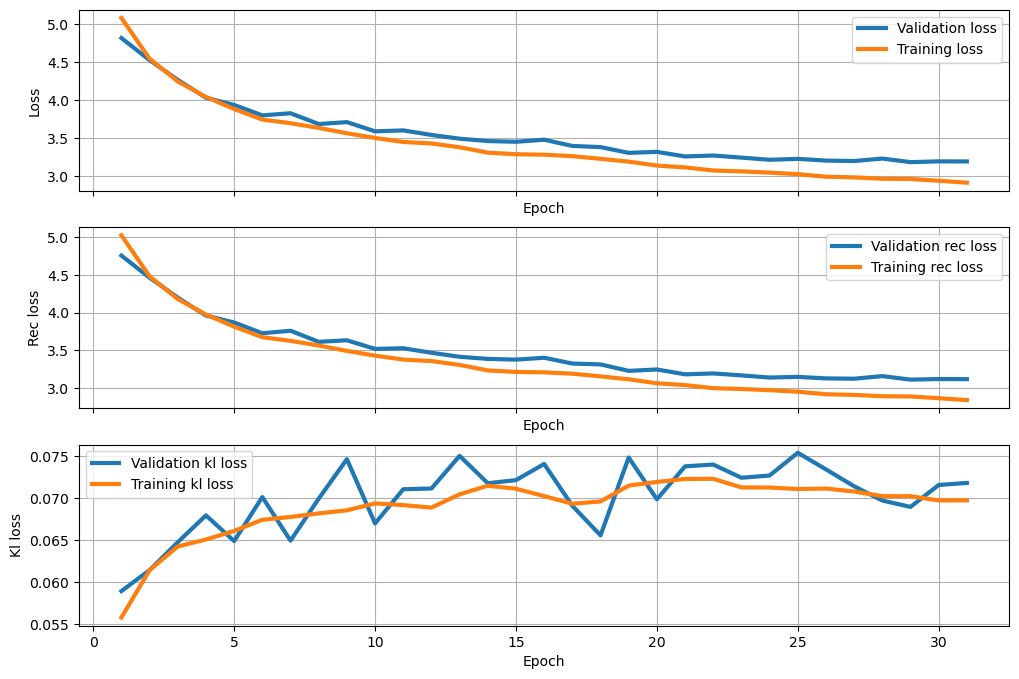

In [126]:
plot_history(hist[1:])

test_loss: 3.3214 - test_rec_loss: 3.2495 - test_kl_loss: 0.0719


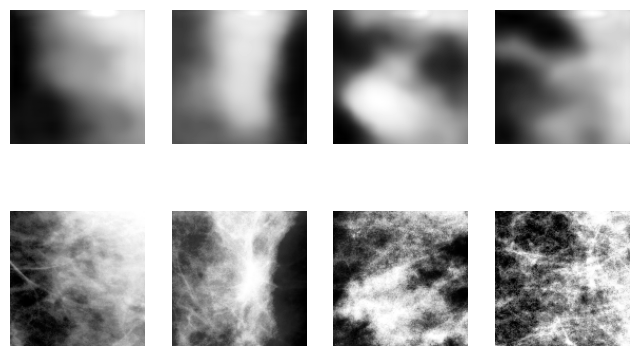

In [127]:
test_metrics = validate(rVae, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(rVae, dataloaders['test'])

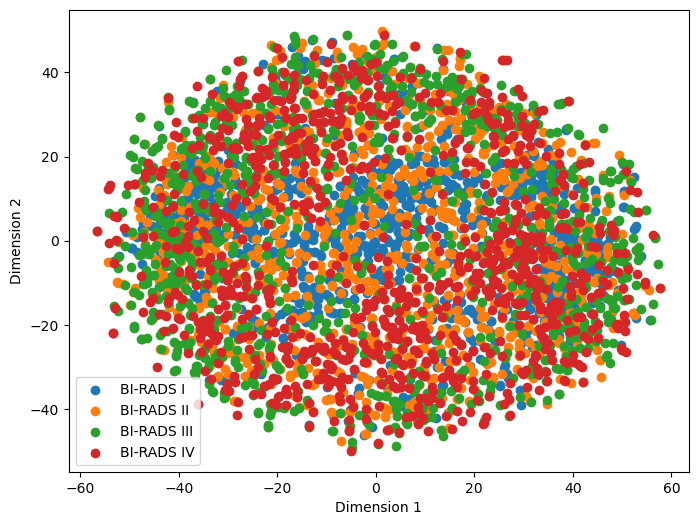

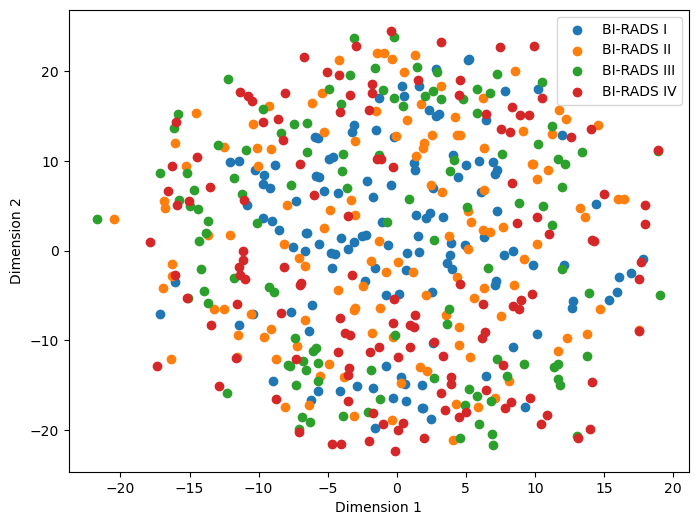

In [128]:
train_latent, train_labels = get_latent(rVae, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(rVae, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [129]:
train_latent, train_labels = get_latent(rVae, dataloaders["train"])
val_latent, val_labels = get_latent(rVae, dataloaders["val"])
latent, labels = get_latent(rVae, dataloaders["test"])

In [130]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [132]:
batch_size = 32

In [133]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [143]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(64, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 8,320
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 82,756
Trainable params: 82,756
Non-trainable params: 0
Total mult-adds (M): 2.65
Input size (MB): 0.01
Forward/backward pass 

In [144]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.00005)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist_pred = train(pred_model, optimizer, train_dl, val_dl, 128, pred_loss)

[epoch: 1] train_loss: 1.3858 - train_predict_loss: 1.3858 - train_accuracy: 0.2504 - val_loss: 1.3856 - val_predict_loss: 1.3856 - val_accuracy: 0.2406
[epoch: 2] train_loss: 1.3807 - train_predict_loss: 1.3807 - train_accuracy: 0.3318 - val_loss: 1.3732 - val_predict_loss: 1.3732 - val_accuracy: 0.4314
[epoch: 3] train_loss: 1.3403 - train_predict_loss: 1.3403 - train_accuracy: 0.4413 - val_loss: 1.3167 - val_predict_loss: 1.3167 - val_accuracy: 0.4036
[epoch: 4] train_loss: 1.2905 - train_predict_loss: 1.2905 - train_accuracy: 0.4328 - val_loss: 1.2932 - val_predict_loss: 1.2932 - val_accuracy: 0.4155
[epoch: 5] train_loss: 1.2608 - train_predict_loss: 1.2608 - train_accuracy: 0.4619 - val_loss: 1.2722 - val_predict_loss: 1.2722 - val_accuracy: 0.4374
[epoch: 6] train_loss: 1.2367 - train_predict_loss: 1.2367 - train_accuracy: 0.4841 - val_loss: 1.2587 - val_predict_loss: 1.2587 - val_accuracy: 0.4334
[epoch: 7] train_loss: 1.2232 - train_predict_loss: 1.2232 - train_accuracy: 0.504

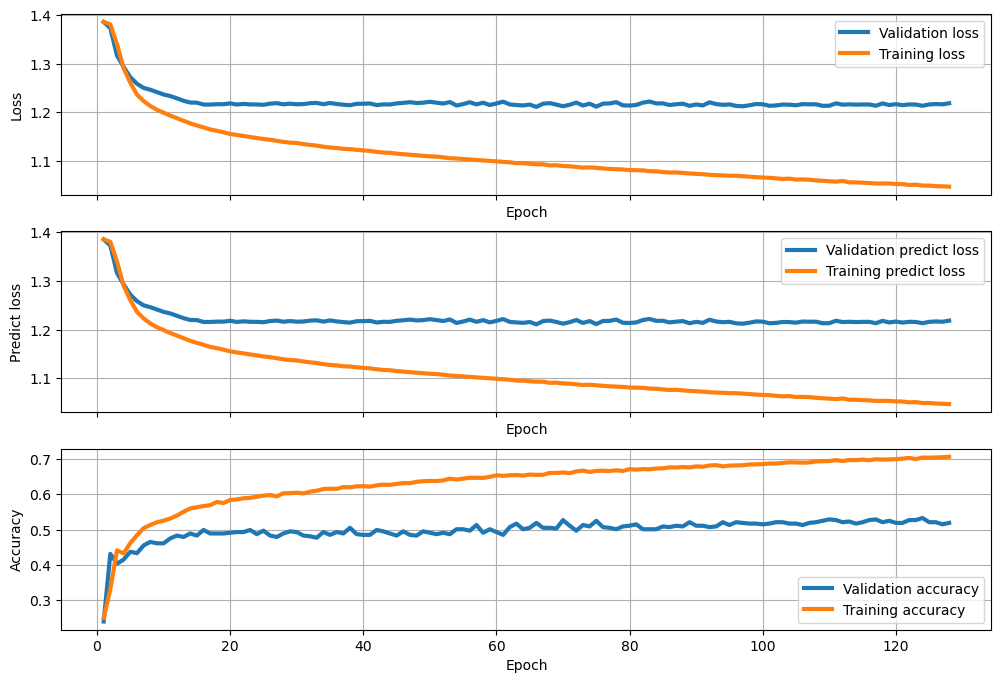

In [145]:
plot_history(hist_pred)

In [146]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.2413 - test_predict_loss: 1.2413 - test_accuracy: 0.4891


In [147]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.80      0.74       129
           1       0.38      0.34      0.36       128
           2       0.38      0.42      0.40       115
           3       0.46      0.40      0.42       131

    accuracy                           0.49       503
   macro avg       0.48      0.49      0.48       503
weighted avg       0.48      0.49      0.48       503



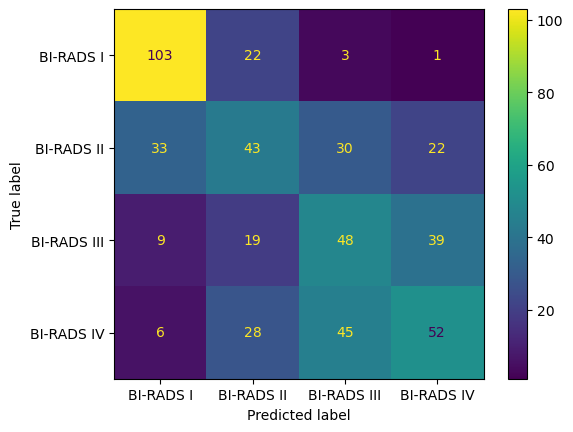

In [148]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()